In [11]:
# IDEA ORIGINAL DEL EJEMPLO: http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers


# Carga de librerías.
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import io
import requests
import warnings

warnings.filterwarnings('ignore')

In [14]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/arbolado-en-espacios-verdes/arbolado-en-espacios-verdes.csv'
arb = requests.get(url).content
data_arbolado_parques = pd.read_csv(io.StringIO(arb.decode('utf-8')))

# columnas que me interesan
col_interes = ['diametro', 'altura_tot', 'nombre_com']
nombre = 'nombre_com'  # nombre común, no científico
nombres_interes = ['Jacarandá', 'Palo borracho rosado', 'Eucalipto', 'Ceibo']

# preparo los dataframe
# selecciono x columnas
data_diametro_altura = data_arbolado_parques[col_interes].copy()
# cambio nombre a 'altura'
data_diametro_altura.rename(columns={'altura_tot': 'altura'}, inplace=True)
diametro_altura_especies = data_diametro_altura[data_diametro_altura['nombre_com'].isin(
    nombres_interes)]
# me quedo con los eucaliptus
euca = diametro_altura_especies[diametro_altura_especies['nombre_com'] == 'Eucalipto']
euca.reset_index(inplace=True)
euca.drop(['nombre_com', 'index'], axis=1, inplace=True)
print(euca.shape)
euca    # (4112, 2)

(4112, 2)


,diametro,altura
0,40,20
1,40,20
2,40,20
3,40,20
4,40,20
...,...,...
4107,74,23
4108,40,7
4109,70,20
4110,40,10


Text(0.5, 1.0, 'Eucaliptus: Altura vs. Diámetro')

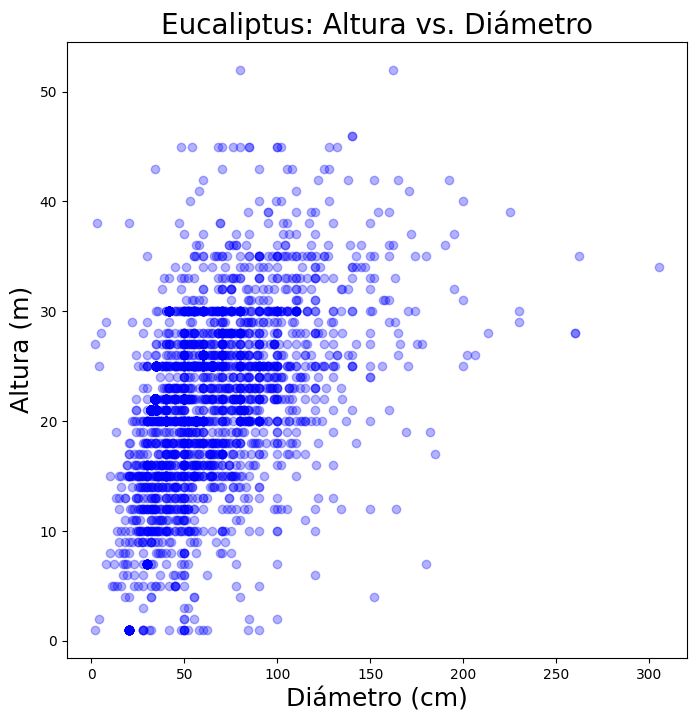

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(euca['diametro'], euca['altura'], 'bo', alpha=0.3)
plt.xlabel('Diámetro (cm)', size=18)
plt.ylabel('Altura (m)', size=18)
plt.title('Eucaliptus: Altura vs. Diámetro', size=20)

In [23]:
euca.describe().T

,count,mean,std,min,25%,50%,75%,max
diametro,4112.0,54.362354,30.043462,2.0,32.0,43.0,68.0,305.0
altura,4112.0,21.647617,6.489263,1.0,20.0,21.0,25.0,52.0


In [25]:
# Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler()
df_escalado = min_max_scaler.fit_transform(euca)
euscalado = pd.DataFrame(df_escalado)
euscalado = euscalado.rename(columns = {0: 'diametro', 1: 'altura'})
euscalado

,diametro,altura
0,0.125413,0.372549
1,0.125413,0.372549
2,0.125413,0.372549
3,0.125413,0.372549
4,0.125413,0.372549
...,...,...
4107,0.237624,0.431373
4108,0.125413,0.117647
4109,0.224422,0.372549
4110,0.125413,0.176471


Text(0, 0.5, 'Altura (m)')

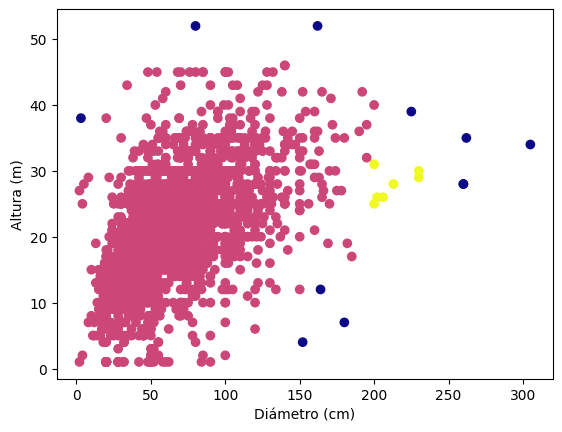

In [29]:
# Ejecutamos DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples = 5, metric = "euclidean").fit(euscalado)
clusters = dbscan.fit_predict(euscalado)
df_values = euca.values
# Graficación de los clústers.
plt.scatter(df_values[:, 0], df_values[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Diámetro (cm)")
plt.ylabel("Altura (m)")

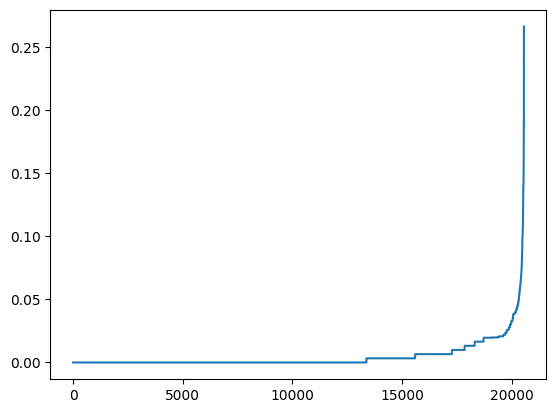

In [28]:
## Parametrización de DBSCAN.
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(euscalado)
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(X_pca)
minPts  = 5 # Fijamos el parámetro minPts
A = kneighbors_graph(X_pca, minPts, include_self=False)
Ar = A.toarray()
seq = []
for i,s in enumerate(X_pca):
    for j in range(len(X_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
seq.sort()
plt.plot(seq)
plt.show()

Text(0, 0.5, 'Altura (m)')

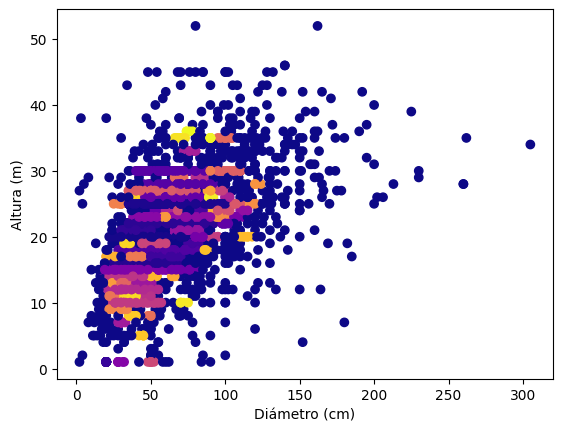

In [33]:
# Ejecutamos DBSCAN
dbscan = DBSCAN(eps=0.0125, min_samples = 5, metric = "euclidean").fit(euscalado)
clusters = dbscan.fit_predict(euscalado)
df_values = euca.values
# Graficación de los clústers.
plt.scatter(df_values[:, 0], df_values[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Diámetro (cm)")
plt.ylabel("Altura (m)")

In [37]:
clusters

array([ 0,  0,  0, ...,  0, 33, -1])

In [34]:
# Vemos cada uno de los clusters cuántos valores tiene.
copy = pd.DataFrame()
copy['altura']=euca['altura'].values
copy['diametro']=euca['diametro'].values
copy['label'] = clusters;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo     # con label=-1 DBSCAN etiqueta los outliers

,cantidad
label,
-1,575
0,183
1,321
2,82
3,693
...,...
70,6
71,5
72,5


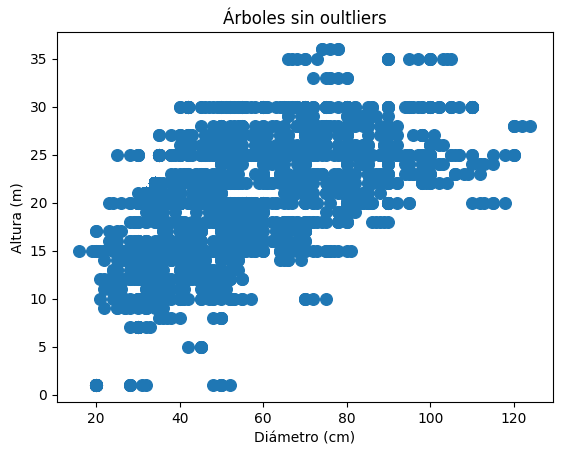

In [38]:
# Eliminamos los puntos marcados como outliers y representamos gráficamente.
copy = copy.drop(copy[copy['label'] == -1].index)

# Gráfica del dataframe "limpio"
f1 = copy['diametro'].values
f2 = copy['altura'].values

plt.scatter(f1, f2, s=70)

plt.xlabel("Diámetro (cm)")
plt.ylabel("Altura (m)")
plt.title("Árboles sin outliers")
plt.show()